<a href="https://colab.research.google.com/github/TAUforPython/fuzzy/blob/main/example%20Fuzzy%20output%20Regression%20via%20Neural%20Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install scikit-fuzzy matplotlib --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 18.5 MB/s eta 0:00:00


In [4]:
# Install scikit-fuzzy if not already available in the environment
# Note: This might not work in all online environments without installation steps
# !pip install scikit-fuzzy matplotlib --quiet

import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
import seaborn as sns


In [5]:

# Set random seed for reproducibility
np.random.seed(0)

# --- 1. Generate Training Data ---
# Using a simple function with noise for a more realistic example
num_samples = 1000
X_train = np.random.rand(num_samples, 3)
# Example: y = 0.5 * x1 + 0.3 * x2 - 0.2 * x3 + noise
y_train = 0.5 * X_train[:, 0] + 0.3 * X_train[:, 1] - 0.2 * X_train[:, 2] + 0.1 * np.random.randn(num_samples)
y_train = y_train.reshape(-1, 1) # Ensure shape is (num_samples, 1)

# --- 2. Define Fuzzy Sets for the OUTPUT (Target Variable) ---
# We define fuzzy sets for the final output prediction (y)
# Let's assume y values range from -0.5 to 1.0 based on our generation function
universe_y = np.arange(-0.5, 1.01, 0.01) # Universe of discourse for output y

# Define membership functions for the output: Low, Medium, High
# Using triangular membership functions
y_lo = fuzz.trimf(universe_y, [-0.5, -0.5, 0.25])  # Low: -0.5 to 0.25
y_md = fuzz.trimf(universe_y, [-0.25, 0.25, 0.75]) # Medium: -0.25 to 0.75
y_hi = fuzz.trimf(universe_y, [0.25, 1.0, 1.0])    # High: 0.25 to 1.0



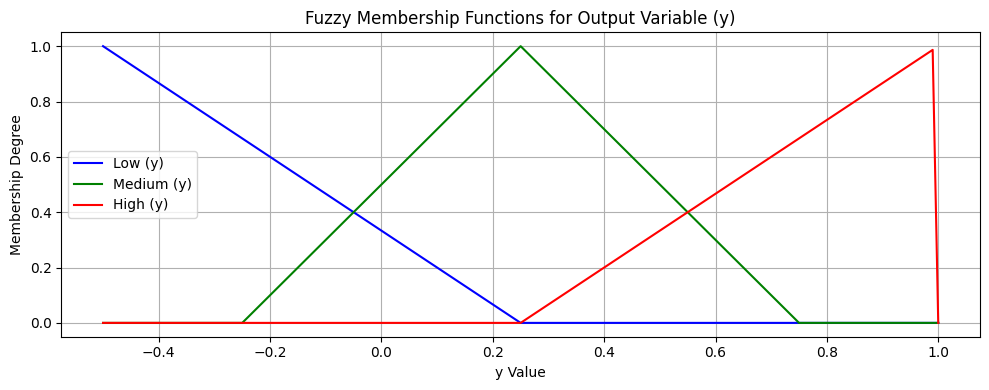

In [6]:
# --- 3. Visualize Fuzzy Sets for Output ---
plt.figure(figsize=(10, 4))
plt.plot(universe_y, y_lo, 'b', linewidth=1.5, label='Low (y)')
plt.plot(universe_y, y_md, 'g', linewidth=1.5, label='Medium (y)')
plt.plot(universe_y, y_hi, 'r', linewidth=1.5, label='High (y)')
plt.title('Fuzzy Membership Functions for Output Variable (y)')
plt.ylabel('Membership Degree')
plt.xlabel('y Value')
plt.ylim(-0.05, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:

# --- 4. Build and Train the Neural Network ---
model = Sequential()
model.add(Dense(10, input_dim=3, activation='relu')) # Input layer
model.add(Dense(10, activation='relu'))              # Hidden layer 1
model.add(Dense(10, activation='relu'))              # Hidden layer 2
model.add(Dense(1, activation='linear'))             # Output layer for regression

model.compile(loss='mse', optimizer='adam', metrics=['mae'])
print("Training the neural network...")
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# --- 5. Generate Test Data and Make Predictions ---
X_test = np.random.rand(100, 3) # Larger test set for better analysis
y_true_test = 0.5 * X_test[:, 0] + 0.3 * X_test[:, 1] - 0.2 * X_test[:, 2] + 0.1 * np.random.randn(len(X_test))
y_true_test = y_true_test.reshape(-1, 1)
y_pred_nn = model.predict(X_test)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training the neural network...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


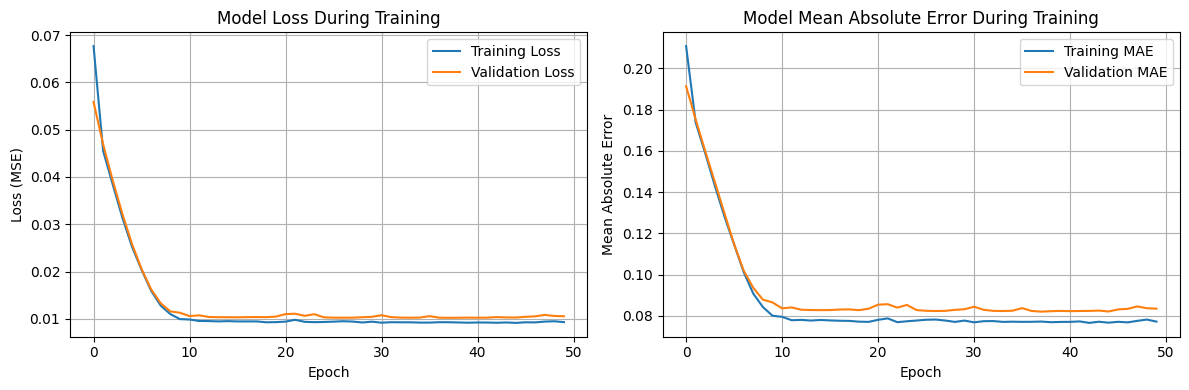

In [8]:
# --- 7. Visualize Training History ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error During Training')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

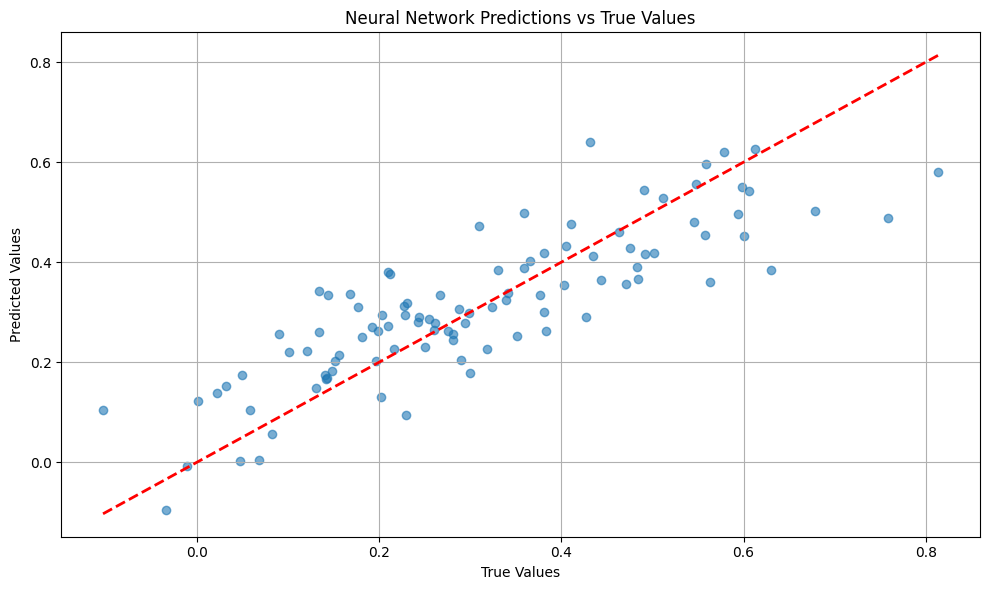

In [9]:


# --- 6. Apply Fuzzy Categorization to Neural Network Predictions ---
# Calculate membership degrees for each prediction
y_pred_cat = []
for pred_val in y_pred_nn.flatten():
    # Calculate membership in each fuzzy set for the specific predicted value
    lo_degree = fuzz.interp_membership(universe_y, y_lo, pred_val)
    md_degree = fuzz.interp_membership(universe_y, y_md, pred_val)
    hi_degree = fuzz.interp_membership(universe_y, y_hi, pred_val)

    # Determine the category with the highest membership degree (Max-Min method)
    if max(lo_degree, md_degree, hi_degree) == lo_degree:
        y_pred_cat.append(0) # 'Low' -> 0
    elif max(lo_degree, md_degree, hi_degree) == md_degree:
        y_pred_cat.append(1) # 'Medium' -> 1
    else: # max(...) == hi_degree
        y_pred_cat.append(2) # 'High' -> 2

# Similarly categorize the true values for the confusion matrix
y_true_cat = []
for true_val in y_true_test.flatten():
    lo_degree = fuzz.interp_membership(universe_y, y_lo, true_val)
    md_degree = fuzz.interp_membership(universe_y, y_md, true_val)
    hi_degree = fuzz.interp_membership(universe_y, y_hi, true_val)

    if max(lo_degree, md_degree, hi_degree) == lo_degree:
        y_true_cat.append(0)
    elif max(lo_degree, md_degree, hi_degree) == md_degree:
        y_true_cat.append(1)
    else:
        y_true_cat.append(2)



# --- 8. Visualize Predictions vs True Values ---
plt.figure(figsize=(10, 6))
plt.scatter(y_true_test, y_pred_nn, alpha=0.6)
plt.plot([y_true_test.min(), y_true_test.max()], [y_true_test.min(), y_true_test.max()], 'r--', lw=2)
plt.title('Neural Network Predictions vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.tight_layout()
plt.show()


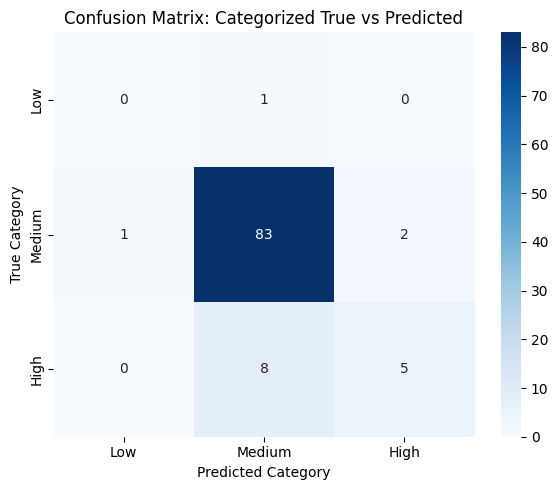


Classification Report for Categorized Predictions:
              precision    recall  f1-score   support

         Low       0.00      0.00      0.00         1
      Medium       0.90      0.97      0.93        86
        High       0.71      0.38      0.50        13

    accuracy                           0.88       100
   macro avg       0.54      0.45      0.48       100
weighted avg       0.87      0.88      0.87       100


--- How the Improved Code Works ---
1.  Data Generation: Creates synthetic input (X) and output (y) data.
2.  Fuzzy Sets: Defines fuzzy categories ('Low', 'Medium', 'High') for the output variable (y).
3.  Neural Network: A simple feedforward network is built and trained to predict the continuous y value.
4.  Prediction: The trained network predicts continuous values for a test set.
5.  Fuzzy Categorization: Each continuous prediction is mapped to a fuzzy category based on its membership degree in the defined sets.
6.  Visualization: Plots show the fuzzy sets,

In [10]:

# --- 9. Create and Visualize Confusion Matrix for Categorized Results ---
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true_cat, y_pred_cat, labels=[0, 1, 2])
labels = ['Low', 'Medium', 'High']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix: Categorized True vs Predicted')
plt.xlabel('Predicted Category')
plt.ylabel('True Category')
plt.tight_layout()
plt.show()

# --- 10. Print Classification Report ---
print("\nClassification Report for Categorized Predictions:")
print(classification_report(y_true_cat, y_pred_cat, target_names=labels, zero_division=0))

# --- 11. Explanation ---
print("\n--- How the Improved Code Works ---")
print("1.  Data Generation: Creates synthetic input (X) and output (y) data.")
print("2.  Fuzzy Sets: Defines fuzzy categories ('Low', 'Medium', 'High') for the output variable (y).")
print("3.  Neural Network: A simple feedforward network is built and trained to predict the continuous y value.")
print("4.  Prediction: The trained network predicts continuous values for a test set.")
print("5.  Fuzzy Categorization: Each continuous prediction is mapped to a fuzzy category based on its membership degree in the defined sets.")
print("6.  Visualization: Plots show the fuzzy sets, training progress, prediction accuracy, and the confusion matrix for categorized results.")
print("7.  Confusion Matrix: Compares the categorical labels of true and predicted values.")